<a href="https://colab.research.google.com/github/Ramakrish21/plant-disease-predictor/blob/main/training_image_based_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/Ramakrish21/plant-disease-predictor.git

Cloning into 'plant-disease-predictor'...
remote: Enumerating objects: 23421, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 23421 (delta 1), reused 12 (delta 1), pack-reused 23406 (from 3)
Receiving objects: 100% (23421/23421), 336.32 MiB | 13.81 MiB/s, done.
Resolving deltas: 100% (168/168), done.
Updating files: 100% (45904/45904), done.
Filtering content: 100% (23/23), 123.43 MiB | 24.77 MiB/s, done.


In [ ]:
%cd plant-disease-predictor/
!ls

/content/plant-disease-predictor
ai-service  backend  frontend


**Required Libraries**

In [ ]:
import os
import shutil
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from google.colab import drive
from warnings import filterwarnings

filterwarnings('ignore')

**Importing and Data Collection**

In [ ]:
DATA_DIR = '/content/plant-disease-predictor/ai-service/data/processed'
batch_size = 32   # Total Images Split into batches and Maximum 32 Images are in Single Batch
image_size = 256  # All Images are resized into 256x256 Pixels unique size

class_names = sorted([
    folder_name for folder_name in os.listdir(DATA_DIR)
    if os.path.isdir(os.path.join(DATA_DIR, folder_name))
])

# Creating a Image Dataset Using TensorFlow
dataset = tf.keras.utils.image_dataset_from_directory(
    directory=DATA_DIR,
    batch_size=batch_size,     # Number of images per batch (32)
    image_size=(image_size, image_size),  # Resize images to 256x256
    shuffle=True
)

dataset

Found 2152 files belonging to 5 classes.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
# Target Label Class Names
class_names = dataset.class_names
class_names

['Early_Blight_Mild',
 'Early_Blight_Severe',
 'Healthy',
 'Late_Blight_Mild',
 'Late_Blight_Severe']

In [ ]:
len(dataset) #total number of batches (groups of images) in the dataset

68

In [ ]:
68 *  batch_size   # Maximum Number of Images Count

2176

In [ ]:
32 - (2176 - 2152) ## Number of images in the last batch (not a full batch)

8

**Data Preprocessing and Pipeline**

In [ ]:
# Define a Function process to Split Dataset into Training(80%), Validation(10%) and Testing(10%) Sets

def train_validation_test_split(dataset, train_size=0.8, validation_size=0.1, test_size=0.1, shuffle=True, shuffle_size=10000):
    dataset_batch_count = tf.data.experimental.cardinality(dataset).numpy()  # safer than len(dataset)
    train_batch_count = int(dataset_batch_count * train_size)                # int(68*0.8) ---> 54 Batches are Training
    validation_batch_count = int(dataset_batch_count * validation_size)      # int(68*0.1) ---> 6 Batches are validation
                                                                             # Remaining (8 batches) are Testing

    if shuffle:
        dataset = dataset.shuffle(buffer_size=shuffle_size)                  # Shuffling helps the model generalize better

    train_ds = dataset.take(train_batch_count)                               # First 54 Batches → Training Dataset
    validation_ds = dataset.skip(train_batch_count).take(validation_batch_count)  # Next 6 → Validation Dataset
    test_ds = dataset.skip(train_batch_count + validation_batch_count)       # Remaining 8 → Testing Dataset

    return train_ds, validation_ds, test_ds

In [ ]:
# Apply the Function in Potato Dataset
train_ds, validation_ds, test_ds = train_validation_test_split(dataset)
len(train_ds), len(validation_ds), len(test_ds)

(54, 6, 8)

(256, 256, 3)
[[[112. 103. 120.]
  [109. 100. 117.]
  [107.  98. 115.]
  ...
  [162. 153. 170.]
  [164. 155. 172.]
  [166. 157. 174.]]

 [[116. 107. 124.]
  [111. 102. 119.]
  [106.  97. 114.]
  ...
  [164. 155. 172.]
  [165. 156. 173.]
  [167. 158. 175.]]

 [[118. 110. 125.]
  [111. 103. 118.]
  [103.  95. 110.]
  ...
  [164. 155. 172.]
  [165. 156. 173.]
  [166. 157. 174.]]

 ...

 [[123. 114. 135.]
  [122. 113. 134.]
  [121. 112. 133.]
  ...
  [168. 157. 171.]
  [169. 158. 172.]
  [169. 158. 172.]]

 [[119. 110. 131.]
  [119. 110. 131.]
  [118. 109. 130.]
  ...
  [166. 155. 169.]
  [166. 155. 169.]
  [165. 154. 168.]]

 [[129. 120. 141.]
  [127. 118. 139.]
  [124. 115. 136.]
  ...
  [165. 154. 168.]
  [166. 155. 169.]
  [166. 155. 169.]]]

(32,)
3



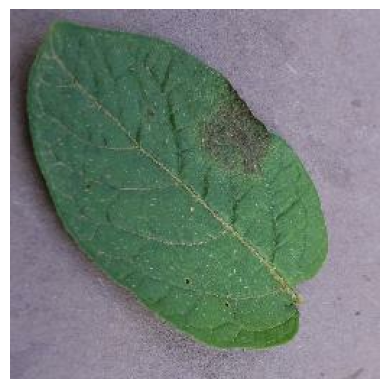

In [ ]:
# Visualize the Image and Label Batches from TensorFlow Dataset

for image_batch, label_batch in train_ds.take(1):
    print(image_batch.numpy()[0].shape)
    print(image_batch.numpy()[0])
    print()

    print(label_batch.numpy().shape)
    print(label_batch.numpy()[0])
    print()

    plt.imshow(image_batch.numpy()[0].astype('uint8'))
    plt.axis('off')


In [ ]:
# Overview of Training Dataset Structure and Specifications
train_ds

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
# Building an Optimized Data Pipeline for Enhanced Performance

# Training Dataset
train_ds = train_ds.cache().shuffle(buffer_size=1000).prefetch(tf.data.AUTOTUNE)

# Validation Dataset
validation_ds = validation_ds.cache().prefetch(tf.data.AUTOTUNE)

# Testing Dataset
test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)

# Overview of Training Dataset Structure and Specifications after Data Pipeline
train_ds


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
# Overview of Training Dataset Structure and Specifications after Data Pipeline
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
# Build a Data Augmentation Pipeline

augmentation_pipeline = keras.Sequential([
                                keras.layers.Resizing(height=image_size, width=image_size),
                                keras.layers.Rescaling(scale=1./255),
                                keras.layers.RandomFlip(mode='horizontal_and_vertical'),
                                keras.layers.RandomRotation(factor=0.2)
                            ])
augmentation_pipeline


<Sequential name=sequential, built=False>

**Model Building and Training**

In [ ]:

# Define the Parameters of Input_shape, Channel and Target

channel = 3  # RGB ---> Color Images
target  = len(class_names)  # Auto detect target classes
input_shape = (batch_size, image_size, image_size, channel)

input_shape

(32, 256, 256, 3)

In [ ]:
# Build a CNN Model Architecture

model = keras.Sequential([

            # Preprocessing Layer
            augmentation_pipeline,

            # 1st Conv Layer
            keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),

            # 2nd Conv Layer
            keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),

            # 3rd Conv Layer
            keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),

            # 4th Conv Layer
            keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),

            # 5th Conv Layer
            keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),

            # 6th Conv Layer
            keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),

            # Flatten to 1-Dimentional Vector
            keras.layers.Flatten(),

            # Fully Connected Dense Layer
            keras.layers.Dense(units=64, activation='relu'),

            # Output Layer
            keras.layers.Dense(units=target, activation='softmax')
        ])
model

<Sequential name=sequential_1, built=False>

In [ ]:
# Display the Model Summary

model.build(input_shape)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 5)                │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,877 (718.27 KB)

 Trainable params: 183,877 (718.27 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compiling the Model with Optimizer, Loss, and Metrics

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model


<Sequential name=sequential_1, built=True>

In [ ]:

# Model Training with Training_Dataset and Evaluated with Validation_Dataset

history = model.fit(train_ds,
                    batch_size=batch_size,
                    epochs=35,
                    verbose=1,
                    validation_data = validation_ds)
history

Epoch 1/35
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 113ms/step - accuracy: 0.3713 - loss: 1.4168 - val_accuracy: 0.4427 - val_loss: 1.3930
Epoch 2/35
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.4277 - loss: 1.2413 - val_accuracy: 0.4948 - val_loss: 1.1254
Epoch 3/35
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.5520 - loss: 1.1293 - val_accuracy: 0.5260 - val_loss: 1.0977
Epoch 4/35
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.5719 - loss: 1.0053 - val_accuracy: 0.6510 - val_loss: 0.8279
Epoch 5/35
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.6941 - loss: 0.7947 - val_accuracy: 0.7812 - val_loss: 0.5270
Epoch 6/35
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.7556 - loss: 0.6036 - val_accuracy: 0.7604 - val_loss: 0.5012
Epoch 7/35
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.7838 - loss: 0.5426 - val_accuracy: 0.8125 - val_loss: 0.4681
Epoch 8/35
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.7930 - loss: 0.5151 - val_accuracy: 0.7760 -

In [ ]:
# --- 1. Evaluate on Test Data ---
print("Evaluating model on the test dataset...")
scores = model.evaluate(test_ds)
print(f"\nTest Accuracy: {scores[1]*100:.2f}%")
print(f"Test Loss: {scores[0]:.4f}")

Evaluating model on the test dataset...
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8955 - loss: 0.2703

Test Accuracy: 90.95%
Test Loss: 0.2541


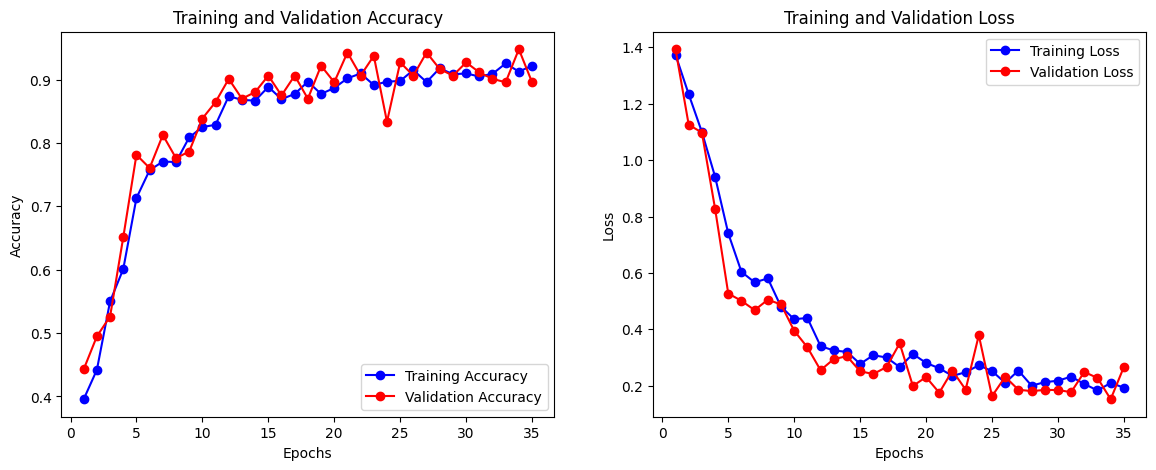

In [ ]:
# --- 2. Visualize Training History ---
# Extract accuracy and loss from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plot Training & Validation Accuracy
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


# Plot Training & Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:

# Accessing Training History Parameters
history.params

{'verbose': 1, 'epochs': 35, 'steps': 54}

In [ ]:
# Accessing Keys of Training History
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [ ]:
# Extracting Accuracy Metrics from Training History
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Extracting Loss Metrics from Training History
loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
acc[0:5]

[0.39553990960121155,
 0.44190141558647156,
 0.5498826503753662,
 0.6009389758110046,
 0.7130281925201416]

In [ ]:
len(acc), len(val_acc), len(loss), len(val_loss)

(35, 35, 35, 35)

In [ ]:
# Save the Model
model.save('/content/plant-disease-predictor/ai-service/ai-model/Model/potato_cnn_image_only.h5')

**Model Inference**

In [ ]:
class_names = dataset.class_names
class_names

['Early_Blight_Mild',
 'Early_Blight_Severe',
 'Healthy',
 'Late_Blight_Mild',
 'Late_Blight_Severe']

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# --- 1. Create the Inference Function ---

def prediction(image_path, class_names = dataset.class_names):

    # Read and Resize the Image using OpenCV
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256, 256))

    # Read and Resize the Image using Pillow
    # img = Image.open(image_path).resize((image_size,image_size))

    img_array = tf.keras.preprocessing.image.img_to_array(img)  # Converting Image to Array using TensorFlow
    img_array = np.expand_dims(img_array, axis=0)               # Expanding Image Array to Include Batch Dimension: (256, 256, 3) to (1, 256, 256, 3)

    model = tf.keras.models.load_model('/content/plant-disease-predictor/ai-service/ai-model/Model/model.h5')     # Load the Trained TensorFlow Model
    prediction = model.predict(img_array)                       # Predict the Index of Class_Label

    predicted_class = class_names[np.argmax(prediction)]        # Find out the Class_Label_Name from Prediction_Dict (Using Max Probability Index)
    confidence = round(np.max(prediction)*100, 2)               # Calculate the Model Confidence

    print(f'Predicted Class : {predicted_class}')
    print(f'Confident : {confidence}%')
    print('')
    plt.imshow(img)
    plt.axis('off')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
Predicted Class : Early_Blight_Mild
Confident : 99.98999786376953%



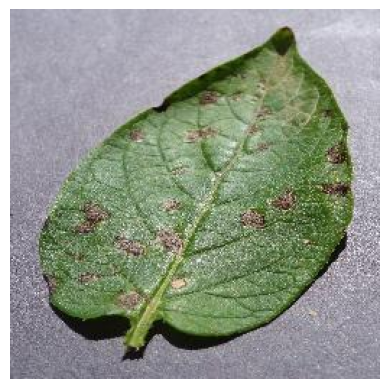

In [ ]:
prediction(image_path = '/content/plant-disease-predictor/ai-service/data/processed/Early_Blight_Mild/0182e991-97f0-4805-a1f7-6e1b4306d518___RS_Early.B 7015.JPG')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
Predicted Class : Healthy
Confident : 100.0%



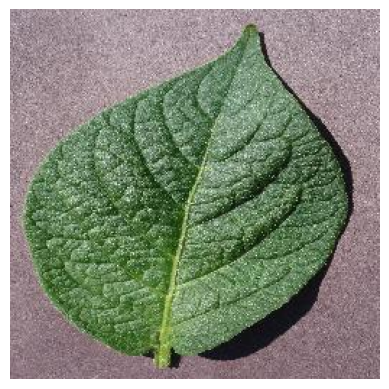

In [ ]:
prediction(image_path = '/content/plant-disease-predictor/ai-service/data/processed/Healthy/1106c3fc-92cb-41a6-a6c6-8f08b9b45108___RS_HL 1914.JPG')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
Predicted Class : Early_Blight_Severe
Confident : 100.0%



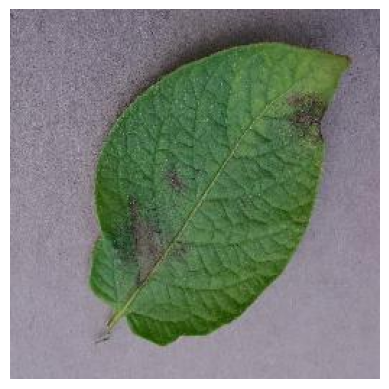

In [ ]:
prediction(image_path = '/content/plant-disease-predictor/ai-service/data/processed/Late_Blight_Mild/02c8ff21-4e0a-4326-ba8f-089e5cb45b74___RS_LB 4089.JPG')

In [ ]:
!git add .

In [ ]:
!git commit -m "Added Image_based Trained model"

[main 9f77c413] Added Image_based Trained model
 1 file changed, 1 insertion(+), 1 deletion(-)
